In [251]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp
from scipy.optimize import minimize, fsolve
import pandas as pd
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks

### Part 1.1

In [252]:
def sir_model_ivp(t, y, beta, gamma):
    """
    SIR model differential equations for solve_ivp
    Note: solve_ivp uses (t, y) order, opposite of odeint
    Parameters:
    t: time
    y: array [S, I, R] - current values
    beta: infection rate
    gamma: recovery rate
    Returns:
    dydt: derivatives [dS/dt, dI/dt, dR/dt]
    """
    S, I, R = y
    N = S + I + R  # Total population (should remain constant = 1)
    dSdt = -beta * S * I
    dIdt = beta * S * I - gamma * I
    dRdt = gamma * I
    return [dSdt, dIdt, dRdt]


In [253]:
def simulate_sir_ivp(beta, gamma, initial_conditions, t_max=100, method='RK45'):
    """
    Simulate SIR model using solve_ivp
    Parameters:
    beta: infection rate
    gamma: recovery rate
    initial_conditions: [S0, I0, R0]
    t_max: maximum simulation time
    method: numerical method to use
    Returns:
    t: time array
    solution: array with S, I, R values over time
    solver_info: diagnostic information
    """
    t_eval = np.linspace(0, t_max, 1000)
    
    sol = solve_ivp(sir_model_ivp, [0, t_max], initial_conditions,
                   t_eval=t_eval, args=(beta, gamma), method=method,
                   rtol=1e-8, atol=1e-10)
    
    solver_info = {
        'method': method,
        'nfev': sol.nfev,
        'success': sol.success,
        'message': sol.message
    }
    
    return sol.t, sol.y.T, solver_info

In [254]:
def analyze_final_epidemic_size(beta, gamma, S0):
    """
    Calculate the final epidemic size using the transcendental equation
    S_∞ = S0 * exp(-R0 * (1 - S_∞))
    """
    R0 = beta / gamma
    if R0 <= 1:
        return S0  # No epidemic
    
    # Solve numerically for S_infinity
    def equation(s_inf):
        return s_inf - S0 * np.exp(-R0 * (1 - s_inf))
    
    s_infinity = fsolve(equation, S0/2)[0]
    return s_infinity

In [255]:
beta_values = [1, 2.5, 3]  # Infection rates
gamma_values = [0.5, 0.1, 1.5]  # Recovery rates

# Initial conditions (closed population: S + I + R = 1)
S0 = 0.99
I0 = 1 - S0
R0_init = 0.0
initial_conditions = [S0, I0, R0_init]
t_max = 15

Solver: scipy.integrate.solve_ivp
Method: RK45 (Runge-Kutta 4th/5th order adaptive)
Tolerance: rtol=1e-8, atol=1e-10
β = 1, γ = 0.5, R₀ = 2.00
  Method: RK45
  Function evaluations: 278
  Success: True
β = 2.5, γ = 0.5, R₀ = 5.00
β = 3, γ = 0.5, R₀ = 6.00
β = 1, γ = 0.1, R₀ = 10.00
β = 2.5, γ = 0.1, R₀ = 25.00
β = 3, γ = 0.1, R₀ = 30.00
β = 1, γ = 1.5, R₀ = 0.67
β = 2.5, γ = 1.5, R₀ = 1.67
β = 3, γ = 1.5, R₀ = 2.00


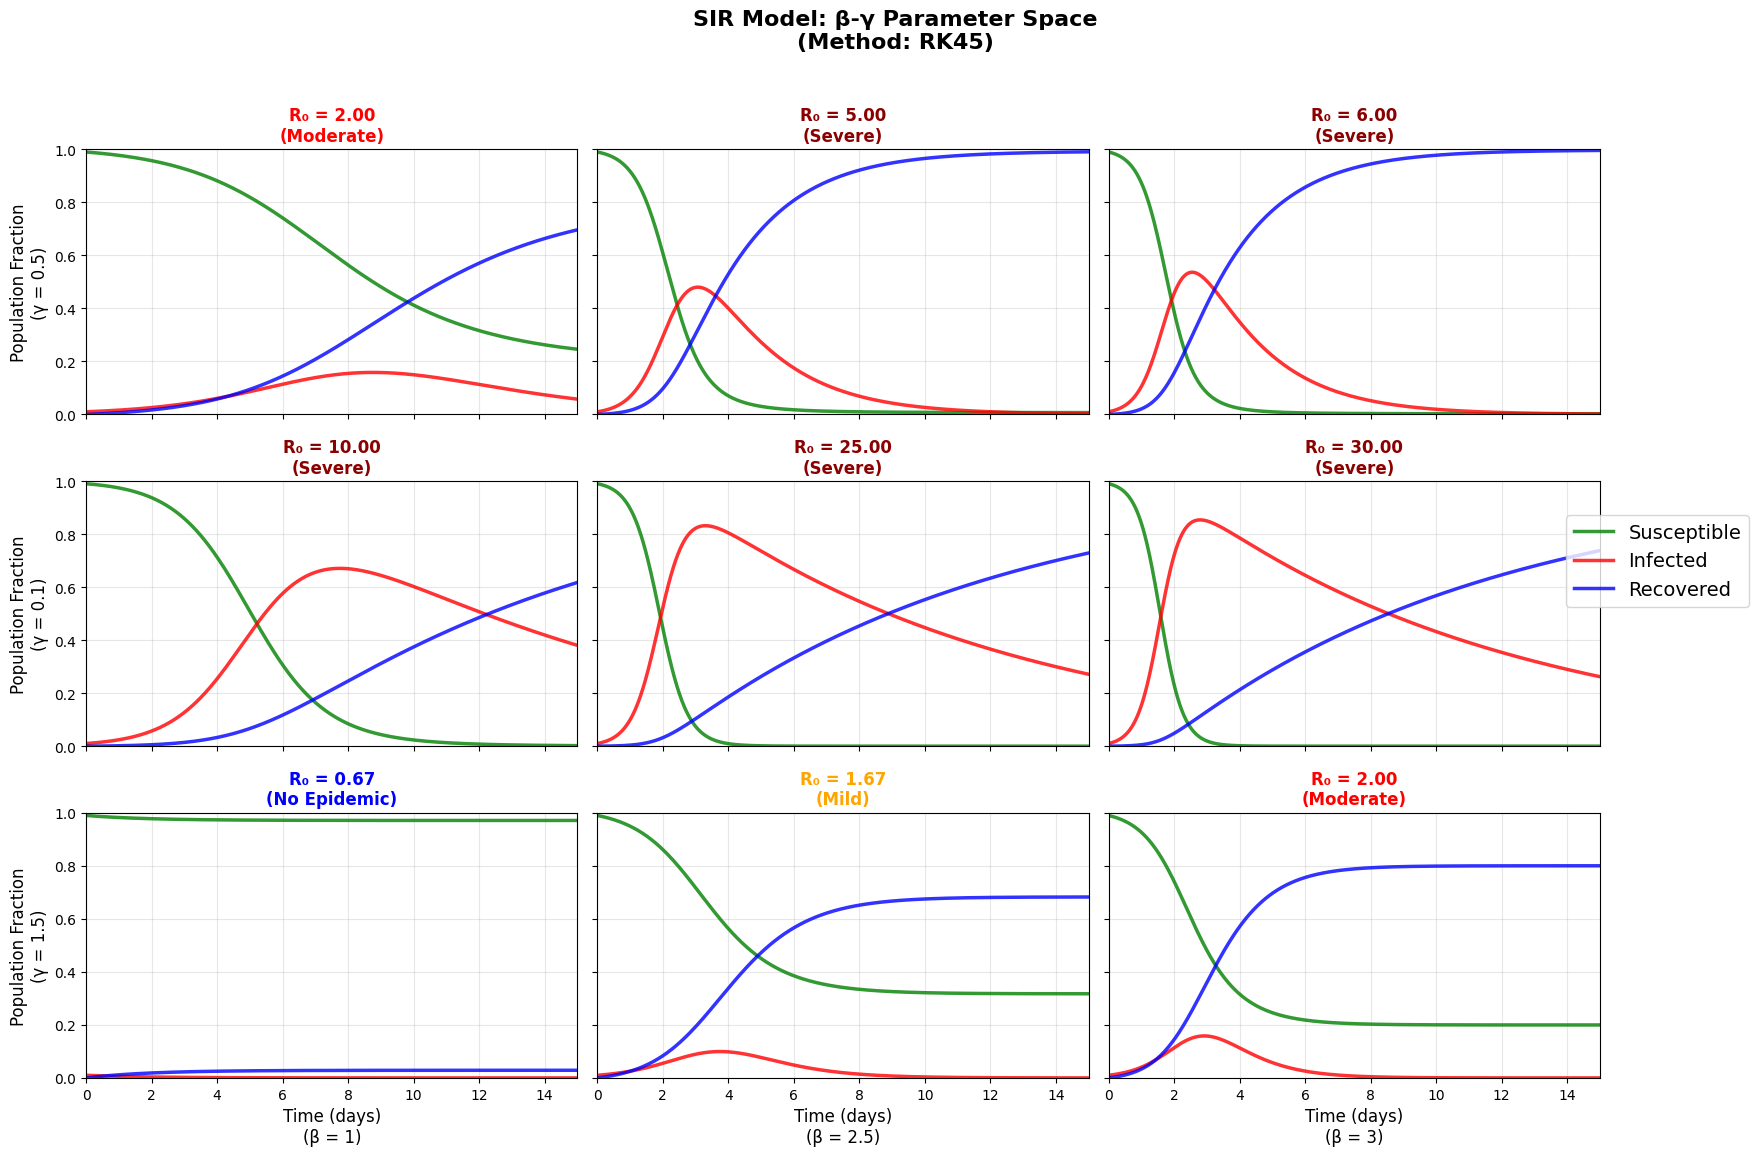

In [256]:
method_used = 'RK45'  # Runge-Kutta 4(5) method
print(f"Solver: scipy.integrate.solve_ivp")
print(f"Method: {method_used} (Runge-Kutta 4th/5th order adaptive)")
print(f"Tolerance: rtol=1e-8, atol=1e-10")

fig, axes = plt.subplots(nrows=len(gamma_values), ncols=len(beta_values), 
                        figsize=(18, 12), sharex=True, sharey=True)

for i, gamma in enumerate(gamma_values):
    for j, beta in enumerate(beta_values):
        R0 = beta / gamma
        print(f"β = {beta}, γ = {gamma}, R₀ = {R0:.2f}")
        
        # Solve SIR equations using solve_ivp
        t, solution, solver_info = simulate_sir_ivp(beta, gamma, initial_conditions, t_max, method_used)
        
        # Print solver info for first case only
        if i == 0 and j == 0:
            print(f"  Method: {solver_info['method']}")
            print(f"  Function evaluations: {solver_info['nfev']}")
            print(f"  Success: {solver_info['success']}")
        
        # Plot on subplot
        ax = axes[i, j]
        ax.plot(t, solution[:, 0], 'g-', label='Susceptible', linewidth=2.5, alpha=0.8)
        ax.plot(t, solution[:, 1], 'r-', label='Infected', linewidth=2.5, alpha=0.8)
        ax.plot(t, solution[:, 2], 'b-', label='Recovered', linewidth=2.5, alpha=0.8)
        
        # Determine epidemic classification
        peak_infection = np.max(solution[:, 1])
        if R0 <= 1:
            epidemic_status = "No Epidemic"
            title_color = 'blue'
        elif peak_infection < 0.1:
            epidemic_status = "Mild"
            title_color = 'orange'
        elif peak_infection < 0.3:
            epidemic_status = "Moderate"
            title_color = 'red'
        else:
            epidemic_status = "Severe"
            title_color = 'darkred'
        
        # Formatting
        ax.set_title(f'R₀ = {R0:.2f}\n({epidemic_status})', 
                    fontsize=12, fontweight='bold', color=title_color)
        ax.set_xlim(0, t_max)
        ax.set_ylim(0, 1)
        ax.grid(True, alpha=0.3)
        ax.tick_params(labelsize=10)
        
        # Labels for edge subplots
        if i == len(gamma_values) - 1:  # Bottom row
            ax.set_xlabel(f'Time (days)\n(β = {beta})', fontsize=12)
        if j == 0:  # Left column
            ax.set_ylabel(f'Population Fraction\n(γ = {gamma})', fontsize=12)

# Add overall legend
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(0.98, 0.5), fontsize=14)

plt.suptitle(f'SIR Model: β-γ Parameter Space\n(Method: {method_used})', 
             fontsize=16, fontweight='bold', y=0.96)
plt.tight_layout(rect=[0, 0, 0.90, 0.94])
plt.show()



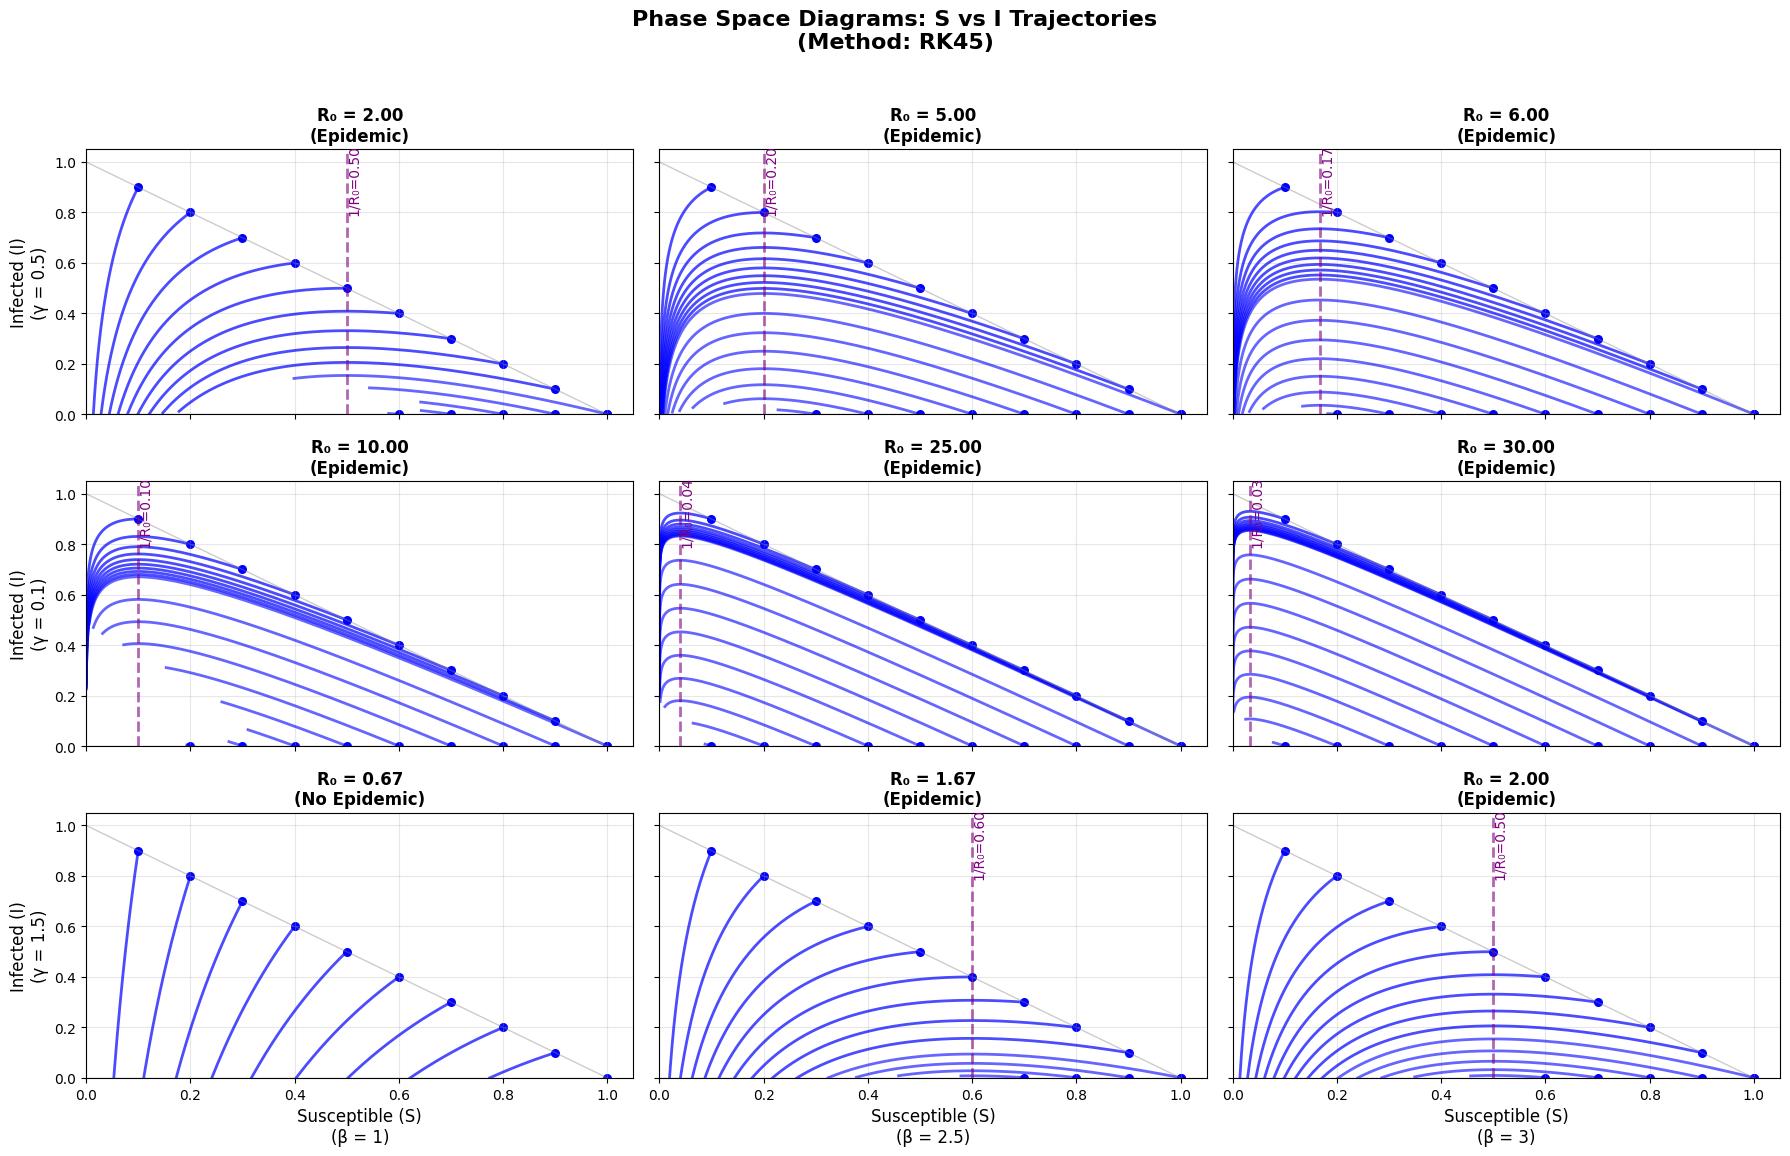

In [257]:
fig, axes = plt.subplots(nrows=len(gamma_values), ncols=len(beta_values), 
                        figsize=(18, 12), sharex=True, sharey=True)

# Multiple initial conditions for phase space analysis
S0_list = np.linspace(0.1, 1, 10)

for i, gamma in enumerate(gamma_values):
    for j, beta in enumerate(beta_values):
        R0 = beta / gamma
        ax = axes[i, j]
        
        # Plot multiple trajectories with different initial conditions
        for k, S0_var in enumerate(S0_list):
            I0_var = 1 - S0_var
            R0_var = 0
            
            if S0_var > 1/R0 and R0 > 1:  # Epidemic condition
                I0_small = 0.001
                R0_small = 1 - I0_small - S0_var
                t_phase, result, _ = simulate_sir_ivp(beta, gamma, [S0_var, I0_small, R0_small], t_max, method_used)
                ax.plot(result[:, 0], result[:, 1], 'b-', alpha=0.6, linewidth=2)
                ax.scatter(S0_var, I0_small, c='blue', s=30)
            
            # Regular trajectory
            t_phase, result, _ = simulate_sir_ivp(beta, gamma, [S0_var, I0_var, R0_var], t_max, method_used)
            ax.plot(result[:, 0], result[:, 1], 'blue', alpha=0.7, linewidth=2)
            ax.scatter(S0_var, I0_var, c='blue', s=30)
        
        # Add critical lines
        ax.plot([0, 1], [1, 0], 'gray', alpha=0.4, linewidth=1, label='S+I=1')
        ax.plot([0, 1], [0, 0], 'gray', alpha=0.4, linewidth=1, label='I=0')
        
        if R0 > 1:
            ax.axvline(x=1/R0, color='purple', linestyle='--', alpha=0.6, 
                      linewidth=2, label=f'S=1/R₀')
            ax.text(1/R0, 0.8, f'1/R₀={1/R0:.2f}', rotation=90, 
                   fontsize=10, color='purple')
        
        # Formatting
        epidemic_type = "Epidemic" if R0 > 1 else "No Epidemic"
        ax.set_title(f'R₀ = {R0:.2f}\n({epidemic_type})', 
                    fontsize=12, fontweight='bold')
        ax.set_xlim(0, 1.05)
        ax.set_ylim(0, 1.05)
        ax.grid(True, alpha=0.3)
        
        if i == len(gamma_values) - 1:  # Bottom row
            ax.set_xlabel(f'Susceptible (S)\n(β = {beta})', fontsize=12)
        if j == 0:  # Left column
            ax.set_ylabel(f'Infected (I)\n(γ = {gamma})', fontsize=12)

plt.suptitle(f'Phase Space Diagrams: S vs I Trajectories\n(Method: {method_used})', 
             fontsize=16, fontweight='bold', y=0.96)
plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()

### Part 1.2

In [258]:
days = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])
infected_data = np.array([1, 3, 8, 28, 75, 221, 291, 255, 235, 190, 125, 70, 28, 12, 5])
N = 763  # Total boys in school

def sir_model_ivp(t, y, beta, gamma, N):
    """
    SIR model for epidemic in closed population
    Modified for solve_ivp interface
    """
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return [dSdt, dIdt, dRdt]

def solve_sir_ivp(y0, t_eval, beta, gamma, N, method='RK45'):
    """Solve SIR using solve_ivp with diagnostics"""
    
    sol = solve_ivp(sir_model_ivp, [t_eval[0], t_eval[-1]], y0,
                   t_eval=t_eval, args=(beta, gamma, N),
                   method=method, rtol=1e-8, atol=1e-10)
    
    return sol.y.T 

In [259]:
# Objective function for least squares fitting
def objective_function(params):
    """
    Minimize sum of squared errors between model predictions and observed data
    """
    beta, gamma = params
    
    # Initial conditions: 1 infected, rest susceptible, none recovered
    S0, I0, R0 = N-1, 1, 0
    y0 = [S0, I0, R0]
    
    try:
        solution = solve_sir_ivp(y0, days, beta, gamma, N)
        I_predicted = solution[:, 1]  # Extract infectious compartment
        
        # Calculate sum of squared errors
        sse = np.sum((I_predicted - infected_data)**2)
        return sse
        
    except:
        return 1e10  # Return large error if integration fails


In [260]:
# Set up optimization
initial_guess = [1.5, 0.4]  # [beta, gamma]
bounds = [(0.1, 5.0), (0.1, 1.0)]

# Perform optimization
result = minimize(objective_function, initial_guess, bounds=bounds, method='L-BFGS-B')

# Extract fitted parameters
beta_fitted = result.x[0]
gamma_fitted = result.x[1]
R0_fitted = beta_fitted / gamma_fitted
infectious_period = 1 / gamma_fitted

S0, I0, R0_init = N-1, 1, 0
y0 = [S0, I0, R0_init]

sol_fitted = solve_sir_ivp(y0, days, beta_fitted, gamma_fitted, N)
I_predicted = sol_fitted[:, 1]

# R-squared calculation
ss_res = np.sum((infected_data - I_predicted)**2)
ss_tot = np.sum((infected_data - np.mean(infected_data))**2)
r_squared = 1 - (ss_res / ss_tot)

In [261]:
print(beta_fitted, gamma_fitted, R0_fitted, infectious_period, r_squared)

1.665116230736307 0.44761002903940106 3.7200154659397375 2.2340875653435694 0.9741481455695409


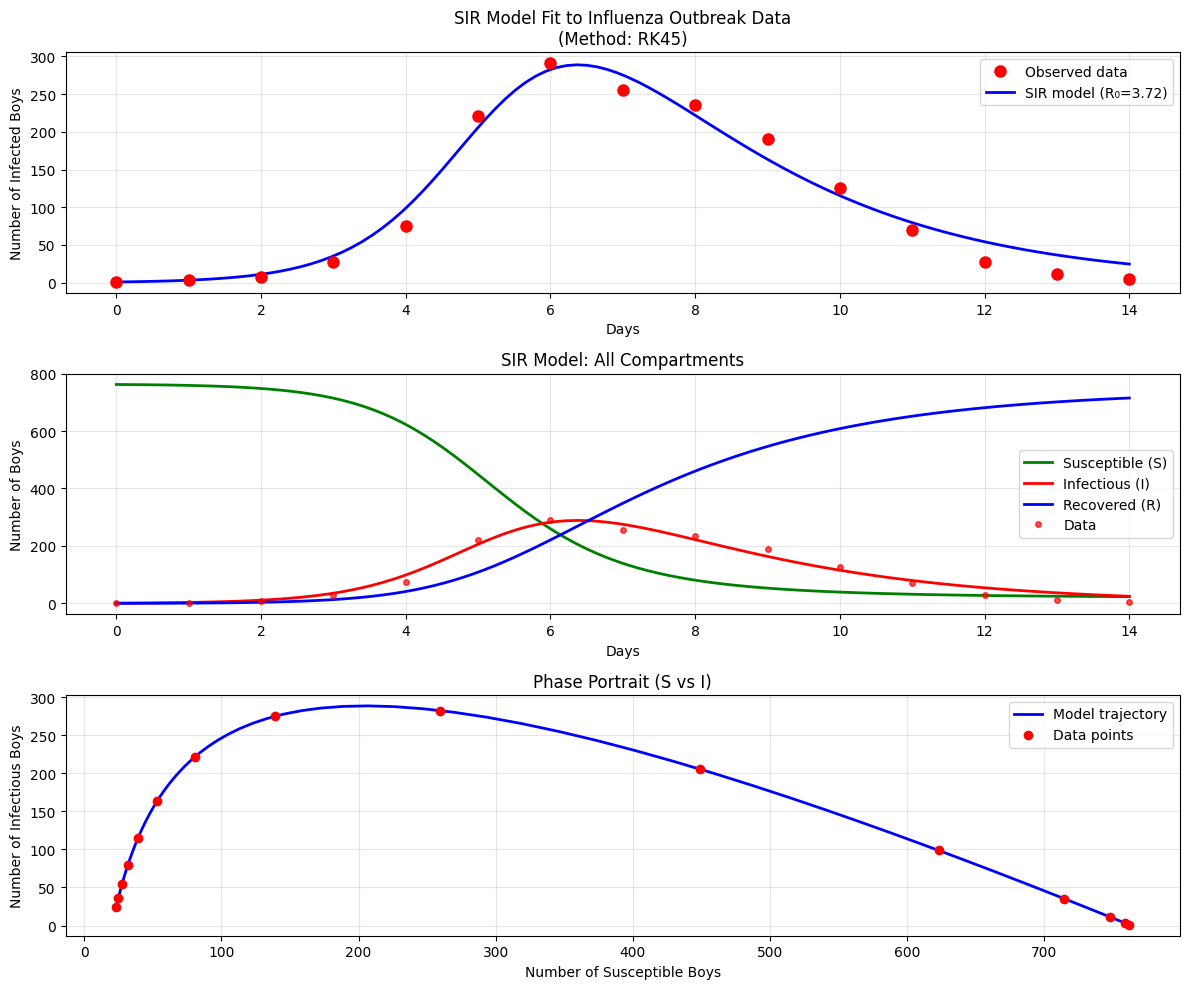

In [262]:
t_smooth = np.linspace(0, 14, 100)
sol_smooth = solve_sir_ivp(y0, t_smooth, beta_fitted, gamma_fitted, N)

fig, ((ax1, ax2, ax3)) = plt.subplots(3, 1, figsize=(12, 10))

# Model fit to data
ax1.plot(days, infected_data, 'ro', markersize=8, label='Observed data', zorder=3)
ax1.plot(t_smooth, sol_smooth[:, 1], 'b-', linewidth=2, 
         label=f'SIR model (R₀={R0_fitted:.2f})', zorder=2)
ax1.set_xlabel('Days')
ax1.set_ylabel('Number of Infected Boys')
ax1.set_title('SIR Model Fit to Influenza Outbreak Data\n(Method: RK45)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# All SIR compartments
ax2.plot(t_smooth, sol_smooth[:, 0], 'g-', linewidth=2, label='Susceptible (S)')
ax2.plot(t_smooth, sol_smooth[:, 1], 'r-', linewidth=2, label='Infectious (I)')
ax2.plot(t_smooth, sol_smooth[:, 2], 'b-', linewidth=2, label='Recovered (R)')
ax2.plot(days, infected_data, 'ro', markersize=4, alpha=0.7, label='Data')
ax2.set_xlabel('Days')
ax2.set_ylabel('Number of Boys')
ax2.set_title('SIR Model: All Compartments')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Phase portrait (S vs I)
ax3.plot(sol_smooth[:, 0], sol_smooth[:, 1], 'b-', linewidth=2, label='Model trajectory')
ax3.plot(sol_fitted[:, 0], sol_fitted[:, 1], 'ro', markersize=6, label='Data points')
ax3.set_xlabel('Number of Susceptible Boys')
ax3.set_ylabel('Number of Infectious Boys')
ax3.set_title('Phase Portrait (S vs I)')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Part 1.3

R0 = 3.69
Critical vaccination coverage (p_c) = 72.89%


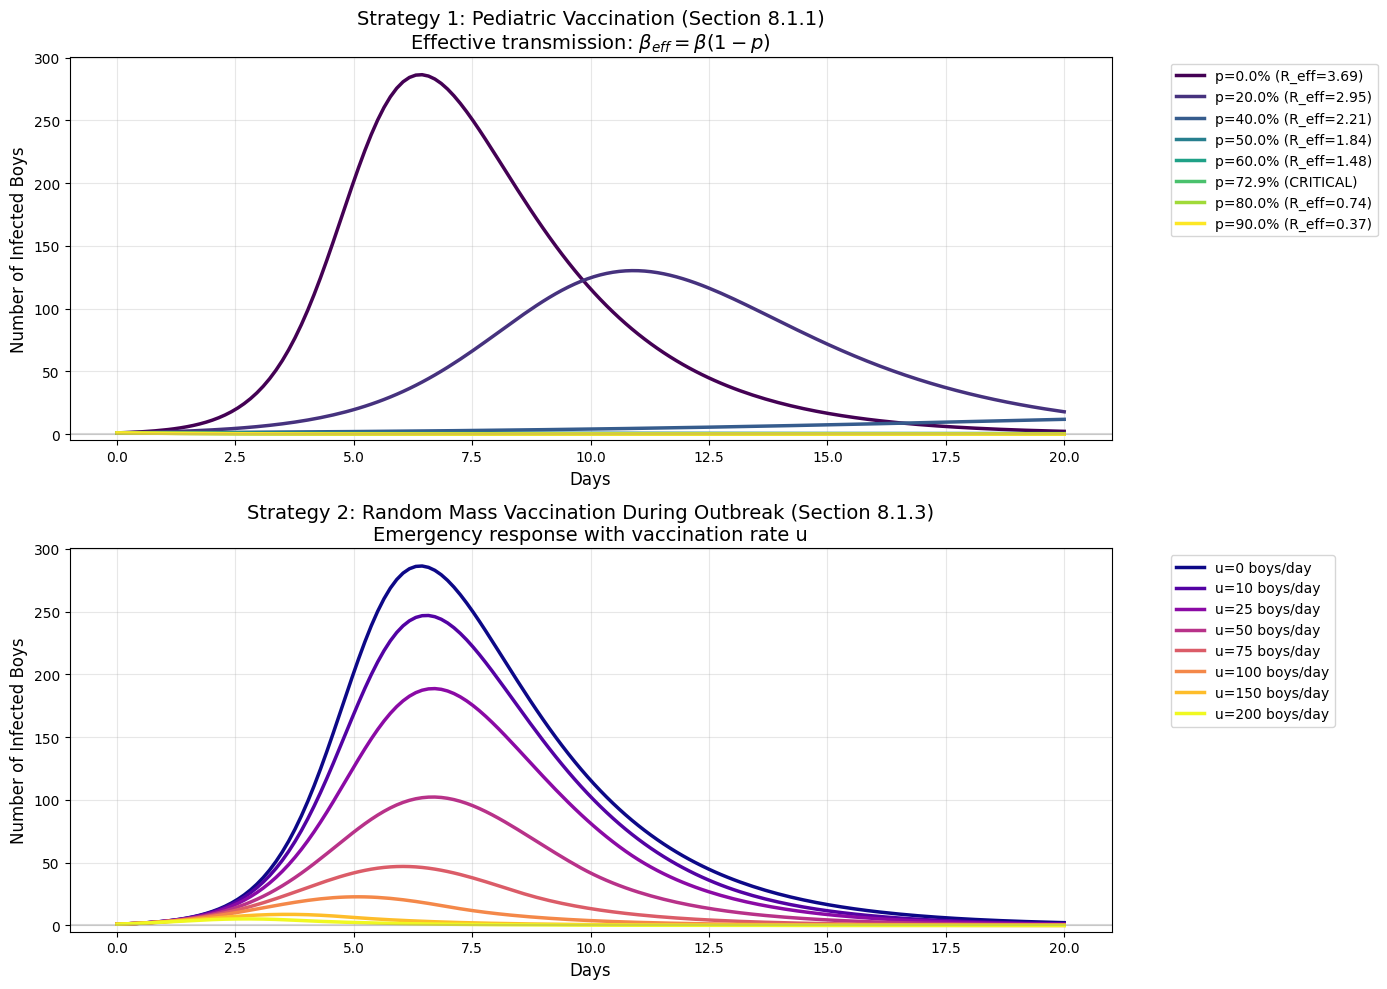

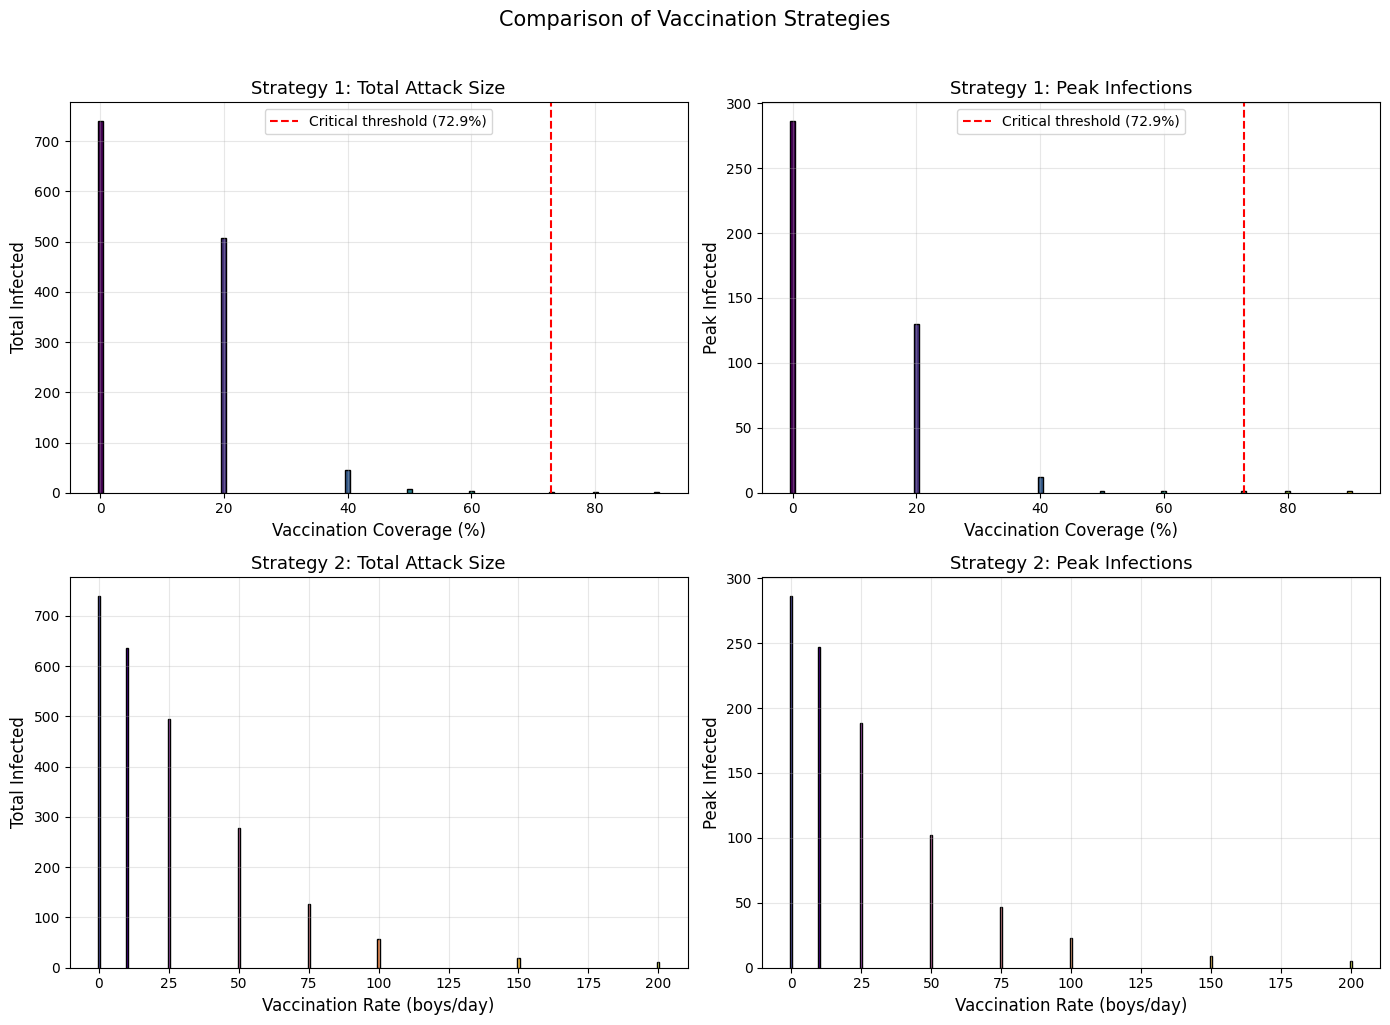


VACCINATION STRATEGY ANALYSIS SUMMARY

STRATEGY 1: PEDIATRIC VACCINATION (Pre-outbreak)
----------------------------------------
Coverage  0.0%: Total infected = 740, Peak = 286, R_eff = 3.69 [EPIDEMIC]
Coverage 20.0%: Total infected = 508, Peak = 130, R_eff = 2.95 [EPIDEMIC]
Coverage 40.0%: Total infected =  45, Peak =  12, R_eff = 2.21 [EPIDEMIC]
Coverage 50.0%: Total infected =   7, Peak =   1, R_eff = 1.84 [EPIDEMIC]
Coverage 60.0%: Total infected =   3, Peak =   1, R_eff = 1.48 [EPIDEMIC]
Coverage 72.9%: Total infected =   2, Peak =   1, R_eff = 1.00 [EPIDEMIC]
Coverage 80.0%: Total infected =   2, Peak =   1, R_eff = 0.74 [ERADICATED]
Coverage 90.0%: Total infected =   2, Peak =   1, R_eff = 0.37 [ERADICATED]

STRATEGY 2: MASS VACCINATION (During outbreak)
----------------------------------------
Rate   0 boys/day: Total infected = 739, Peak = 286, Peak day = 6.4
Rate  10 boys/day: Total infected = 636, Peak = 247, Peak day = 6.6
Rate  25 boys/day: Total infected = 495, Peak = 1

In [263]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

def solve_model_ivp(model_func, y0, t_span, args, method='RK45'):
    """Wrapper for solve_ivp with performance tracking"""
    sol = solve_ivp(model_func, [t_span[0], t_span[-1]], y0,
                    t_eval=t_span, args=args, method=method,
                    rtol=1e-8, atol=1e-10)
    return sol.y.T  # Transpose to match odeint format

def sir_pediatric_vaccination_ivp(t, y, beta, gamma, p, N):
    """
    SIR model with pediatric vaccination (birth vaccination)
    From textbook section 8.1.1 - equation 8.3:
    
    dS'/dt = v - (β(1-p)I' + μ)S'
    dI'/dt = β(1-p)S'I' - (γ+μ)I'
    dR'/dt = γI' - μR'
    
    For closed population (μ=v=0), this simplifies to replacing β with β(1-p)
    
    Parameters:
    p: fraction of newborns vaccinated (coverage × efficacy)
    N: total population
    """
    S, I, R = y
    
    # From textbook: "The transmission rate β is replaced with β(1-p)"
    beta_effective = beta * (1 - p)
    
    dSdt = -beta_effective * S * I / N
    dIdt = beta_effective * S * I / N - gamma * I
    dRdt = gamma * I
    
    return [dSdt, dIdt, dRdt]

def sir_mass_vaccination_ivp(t, y, beta, gamma, u, N):
    """
    SIR model with random mass vaccination during outbreak
    From textbook section 8.1.3 - equation 8.7:
    
    dS/dt = -βSI - u
    dI/dt = βSI - γI  
    dR/dt = gI (where g=γ for recovery)
    dV/dt = u
    
    Parameters:
    u: vaccination rate (individuals per day)
    N: total population
    """
    S, I, R, V = y  # V tracks vaccinated individuals
    
    # Equation 8.7 from textbook
    dSdt = -beta * S * I / N - u
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I  # Note: g = γ in the textbook notation
    dVdt = u
    
    # Stop vaccination when susceptibles reach zero
    if S <= 0:
        dSdt = 0
        dVdt = 0
    
    return [dSdt, dIdt, dRdt, dVdt]


# Assuming these are from your Problem 1.2 fitting
beta_fitted = 1.66 # Adjust to your fitted value
gamma_fitted = 0.45  # Adjust to your fitted value
N = 763  # Total boys in school
R0_fitted = beta_fitted / gamma_fitted

# Critical vaccination threshold from textbook
p_critical = 1 - 1/R0_fitted
print(f"R0 = {R0_fitted:.2f}")
print(f"Critical vaccination coverage (p_c) = {p_critical:.2%}")

# Time span
days = np.linspace(0, 20, 150)

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

vaccination_levels = np.array([0, 0.2, 0.4, 0.5, 0.6, p_critical, 0.8, 0.9])
colors_pediatric = plt.cm.viridis(np.linspace(0, 1, len(vaccination_levels)))

total_infected_pediatric = []
peak_infected_pediatric = []
outbreak_prevented = []

for i, p in enumerate(vaccination_levels):
    # Initial conditions with pre-vaccination
    S0 = (N - 1) * (1 - p)  # Fraction not vaccinated
    I0 = 1
    R0_init = (N - 1) * p  # Fraction vaccinated at birth
    y0 = [S0, I0, R0_init]
    
    # Solve with pediatric vaccination
    sol = solve_model_ivp(sir_pediatric_vaccination_ivp, y0, days,
                         (beta_fitted, gamma_fitted, p, N))
    S_t, I_t, R_t = sol.T
    
    # Calculate metrics
    total_infected_final = I0 + (R_t[-1] - R0_init)
    peak_infected = np.max(I_t)
    R_effective = R0_fitted * (1 - p)
    
    total_infected_pediatric.append(total_infected_final)
    peak_infected_pediatric.append(peak_infected)
    outbreak_prevented.append(R_effective < 1.0)
    
    # Plot
    label = f'p={p:.1%} (R_eff={R_effective:.2f})'
    if abs(p - p_critical) < 0.01:
        label = f'p={p:.1%} (CRITICAL)'
    
    ax1.plot(days, I_t, color=colors_pediatric[i], linewidth=2.5, label=label)

ax1.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
ax1.set_xlabel('Days', fontsize=12)
ax1.set_ylabel('Number of Infected Boys', fontsize=12)
ax1.set_title('Strategy 1: Pediatric Vaccination (Section 8.1.1)\n' + 
              r'Effective transmission: $\beta_{eff} = \beta(1-p)$', fontsize=14)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(bottom=-5)

vaccination_rates = [0, 10, 25, 50, 75, 100, 150, 200]  # boys per day
colors_mass = plt.cm.plasma(np.linspace(0, 1, len(vaccination_rates)))

total_infected_mass = []
peak_infected_mass = []
days_to_peak = []

for i, u in enumerate(vaccination_rates):
    # Initial conditions: outbreak starts in fully susceptible population
    S0 = N - 1
    I0 = 1
    R0_init = 0
    V0 = 0
    y0 = [S0, I0, R0_init, V0]
    
    # Solve with mass vaccination
    sol = solve_model_ivp(sir_mass_vaccination_ivp, y0, days,
                         (beta_fitted, gamma_fitted, u, N))
    S_t, I_t, R_t, V_t = sol.T
    
    # Calculate metrics
    total_infected_final = R_t[-1]  # Total who recovered (were infected)
    peak_infected = np.max(I_t)
    peak_day = days[np.argmax(I_t)]
    
    total_infected_mass.append(total_infected_final)
    peak_infected_mass.append(peak_infected)
    days_to_peak.append(peak_day)
    
    # Plot
    ax2.plot(days, I_t, color=colors_mass[i], linewidth=2.5,
            label=f'u={u} boys/day')

ax2.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
ax2.set_xlabel('Days', fontsize=12)
ax2.set_ylabel('Number of Infected Boys', fontsize=12)
ax2.set_title('Strategy 2: Random Mass Vaccination During Outbreak (Section 8.1.3)\n' +
              'Emergency response with vaccination rate u', fontsize=14)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, alpha=0.3)
ax2.set_ylim(bottom=-5)

plt.tight_layout()
plt.show()


fig2, ((ax3, ax4), (ax5, ax6)) = plt.subplots(2, 2, figsize=(14, 10))

# Pediatric vaccination metrics
ax3.bar(vaccination_levels * 100, total_infected_pediatric, 
        color=colors_pediatric, edgecolor='black', linewidth=1)
ax3.axvline(x=p_critical * 100, color='red', linestyle='--', 
            label=f'Critical threshold ({p_critical:.1%})')
ax3.set_xlabel('Vaccination Coverage (%)', fontsize=12)
ax3.set_ylabel('Total Infected', fontsize=12)
ax3.set_title('Strategy 1: Total Attack Size', fontsize=13)
ax3.legend()
ax3.grid(True, alpha=0.3)

ax4.bar(vaccination_levels * 100, peak_infected_pediatric,
        color=colors_pediatric, edgecolor='black', linewidth=1)
ax4.axvline(x=p_critical * 100, color='red', linestyle='--',
            label=f'Critical threshold ({p_critical:.1%})')
ax4.set_xlabel('Vaccination Coverage (%)', fontsize=12)
ax4.set_ylabel('Peak Infected', fontsize=12)
ax4.set_title('Strategy 1: Peak Infections', fontsize=13)
ax4.legend()
ax4.grid(True, alpha=0.3)

# Mass vaccination metrics
ax5.bar(vaccination_rates, total_infected_mass,
        color=colors_mass, edgecolor='black', linewidth=1)
ax5.set_xlabel('Vaccination Rate (boys/day)', fontsize=12)
ax5.set_ylabel('Total Infected', fontsize=12)
ax5.set_title('Strategy 2: Total Attack Size', fontsize=13)
ax5.grid(True, alpha=0.3)

ax6.bar(vaccination_rates, peak_infected_mass,
        color=colors_mass, edgecolor='black', linewidth=1)
ax6.set_xlabel('Vaccination Rate (boys/day)', fontsize=12)
ax6.set_ylabel('Peak Infected', fontsize=12)
ax6.set_title('Strategy 2: Peak Infections', fontsize=13)
ax6.grid(True, alpha=0.3)

plt.suptitle('Comparison of Vaccination Strategies', fontsize=15, y=1.02)
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("VACCINATION STRATEGY ANALYSIS SUMMARY")
print("="*60)

print("\nSTRATEGY 1: PEDIATRIC VACCINATION (Pre-outbreak)")
print("-"*40)
for i, p in enumerate(vaccination_levels):
    R_eff = R0_fitted * (1 - p)
    status = "ERADICATED" if R_eff < 1.0 else "EPIDEMIC"
    print(f"Coverage {p:5.1%}: Total infected = {total_infected_pediatric[i]:3.0f}, "
          f"Peak = {peak_infected_pediatric[i]:3.0f}, R_eff = {R_eff:.2f} [{status}]")

print("\nSTRATEGY 2: MASS VACCINATION (During outbreak)")
print("-"*40)
for i, u in enumerate(vaccination_rates):
    print(f"Rate {u:3d} boys/day: Total infected = {total_infected_mass[i]:3.0f}, "
          f"Peak = {peak_infected_mass[i]:3.0f}, Peak day = {days_to_peak[i]:.1f}")

print("\n" + "="*60)
print(f"KEY FINDING: Critical vaccination coverage = {p_critical:.1%}")
print(f"This threshold ensures R_effective < 1, preventing epidemic spread")
print("="*60)

### Part 2.1

In [264]:
# SIR model with demography (Section 2.1)
def SIR_demography(t, y, beta, gamma, mu):
    """
    SIR model with births and deaths
    Note: solve_ivp expects (t, y) order, different from odeint
    """
    S, I, R = y
    
    # SIR equations with demography (equations 2.13-2.15)
    dSdt = mu - beta*S*I - mu*S          # births - infection - natural death
    dIdt = beta*S*I - gamma*I - mu*I     # infection - recovery - natural death  
    dRdt = gamma*I - mu*R                # recovery - natural death
    
    return [dSdt, dIdt, dRdt]

In [265]:
beta_values = [1.5, 2.5, 3.5]          # transmission rates (per year)
gamma_values = [0.6, 1.2, 1.8]         # recovery rates (per year)
mu = 1/70                               # birth/death rate (70-year lifespan)

S0 = 0.99                           # most people start susceptible
I0 = 0.01                         # small initial infection
R0_init = 0.0                           # no recovered initially

# Time span for analysis (years)
t_span = (0, 200)
t_eval = np.linspace(0, 200, 800)

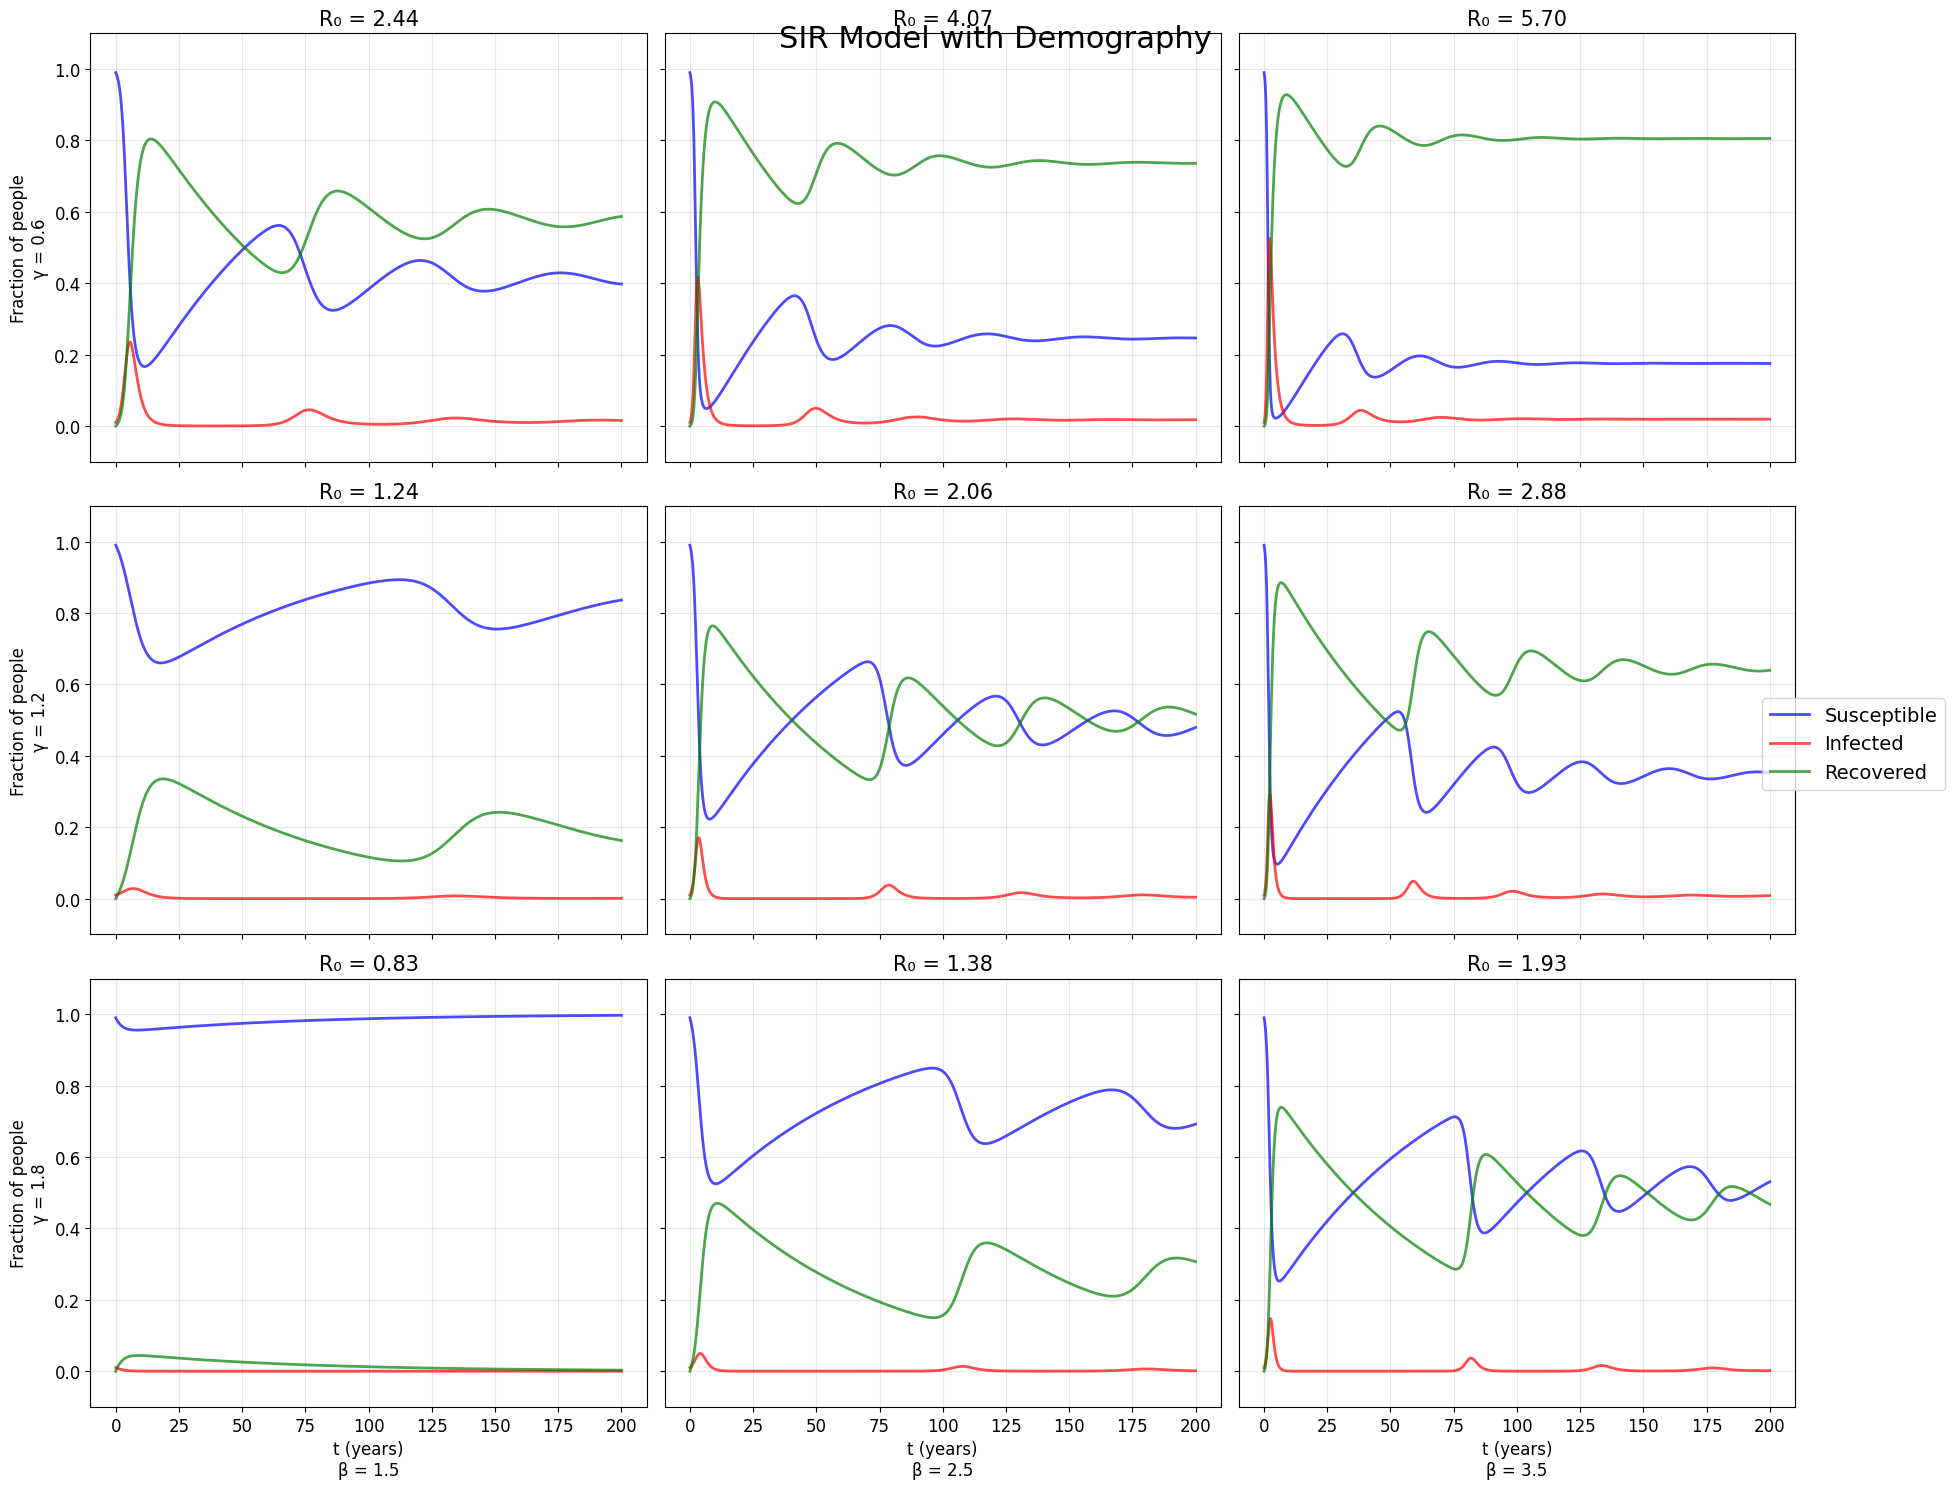

In [266]:
fig, axes = plt.subplots(nrows=len(gamma_values), ncols=len(beta_values), 
                        figsize=(20, 15), sharex=True, sharey=True)

for i, gamma in enumerate(gamma_values):
    for j, beta in enumerate(beta_values):
        
        # Calculate R0 
        R0 = beta / (gamma + mu)
        
        # Solve the system
        solution = solve_ivp(lambda t, y: SIR_demography(t, y, beta, gamma, mu),
                           t_span, [S0, I0, R0_init], t_eval=t_eval, 
                           method='RK45')
        
        t = solution.t
        S, I, R = solution.y
        
        # Plot time series
        axes[i,j].plot(t, S, 'b-', alpha=0.7, linewidth=2, label='Susceptible')
        axes[i,j].plot(t, I, 'r-', alpha=0.7, linewidth=2, label='Infected') 
        axes[i,j].plot(t, R, 'g-', alpha=0.7, linewidth=2, label='Recovered')
        
        axes[i,j].set_ylim(-0.1, 1.1)
        axes[i,j].set_title(f'R₀ = {R0:.2f}', fontsize=15)
        axes[i,j].tick_params(labelsize=12)
        axes[i,j].grid(True, alpha=0.3)
        
        # Add labels
        if i == len(gamma_values)-1:
            axes[i,j].set_xlabel(f't (years)\nβ = {beta}', fontsize=12)
        if j == 0:  # left column
            axes[i,j].set_ylabel(f'Fraction of people\nγ = {gamma}', fontsize=12)

plt.tight_layout()
plt.suptitle('SIR Model with Demography', fontsize=22, y=0.98)
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(0.98, 0.5), fontsize=14)

plt.subplots_adjust(right=0.90)
plt.show()

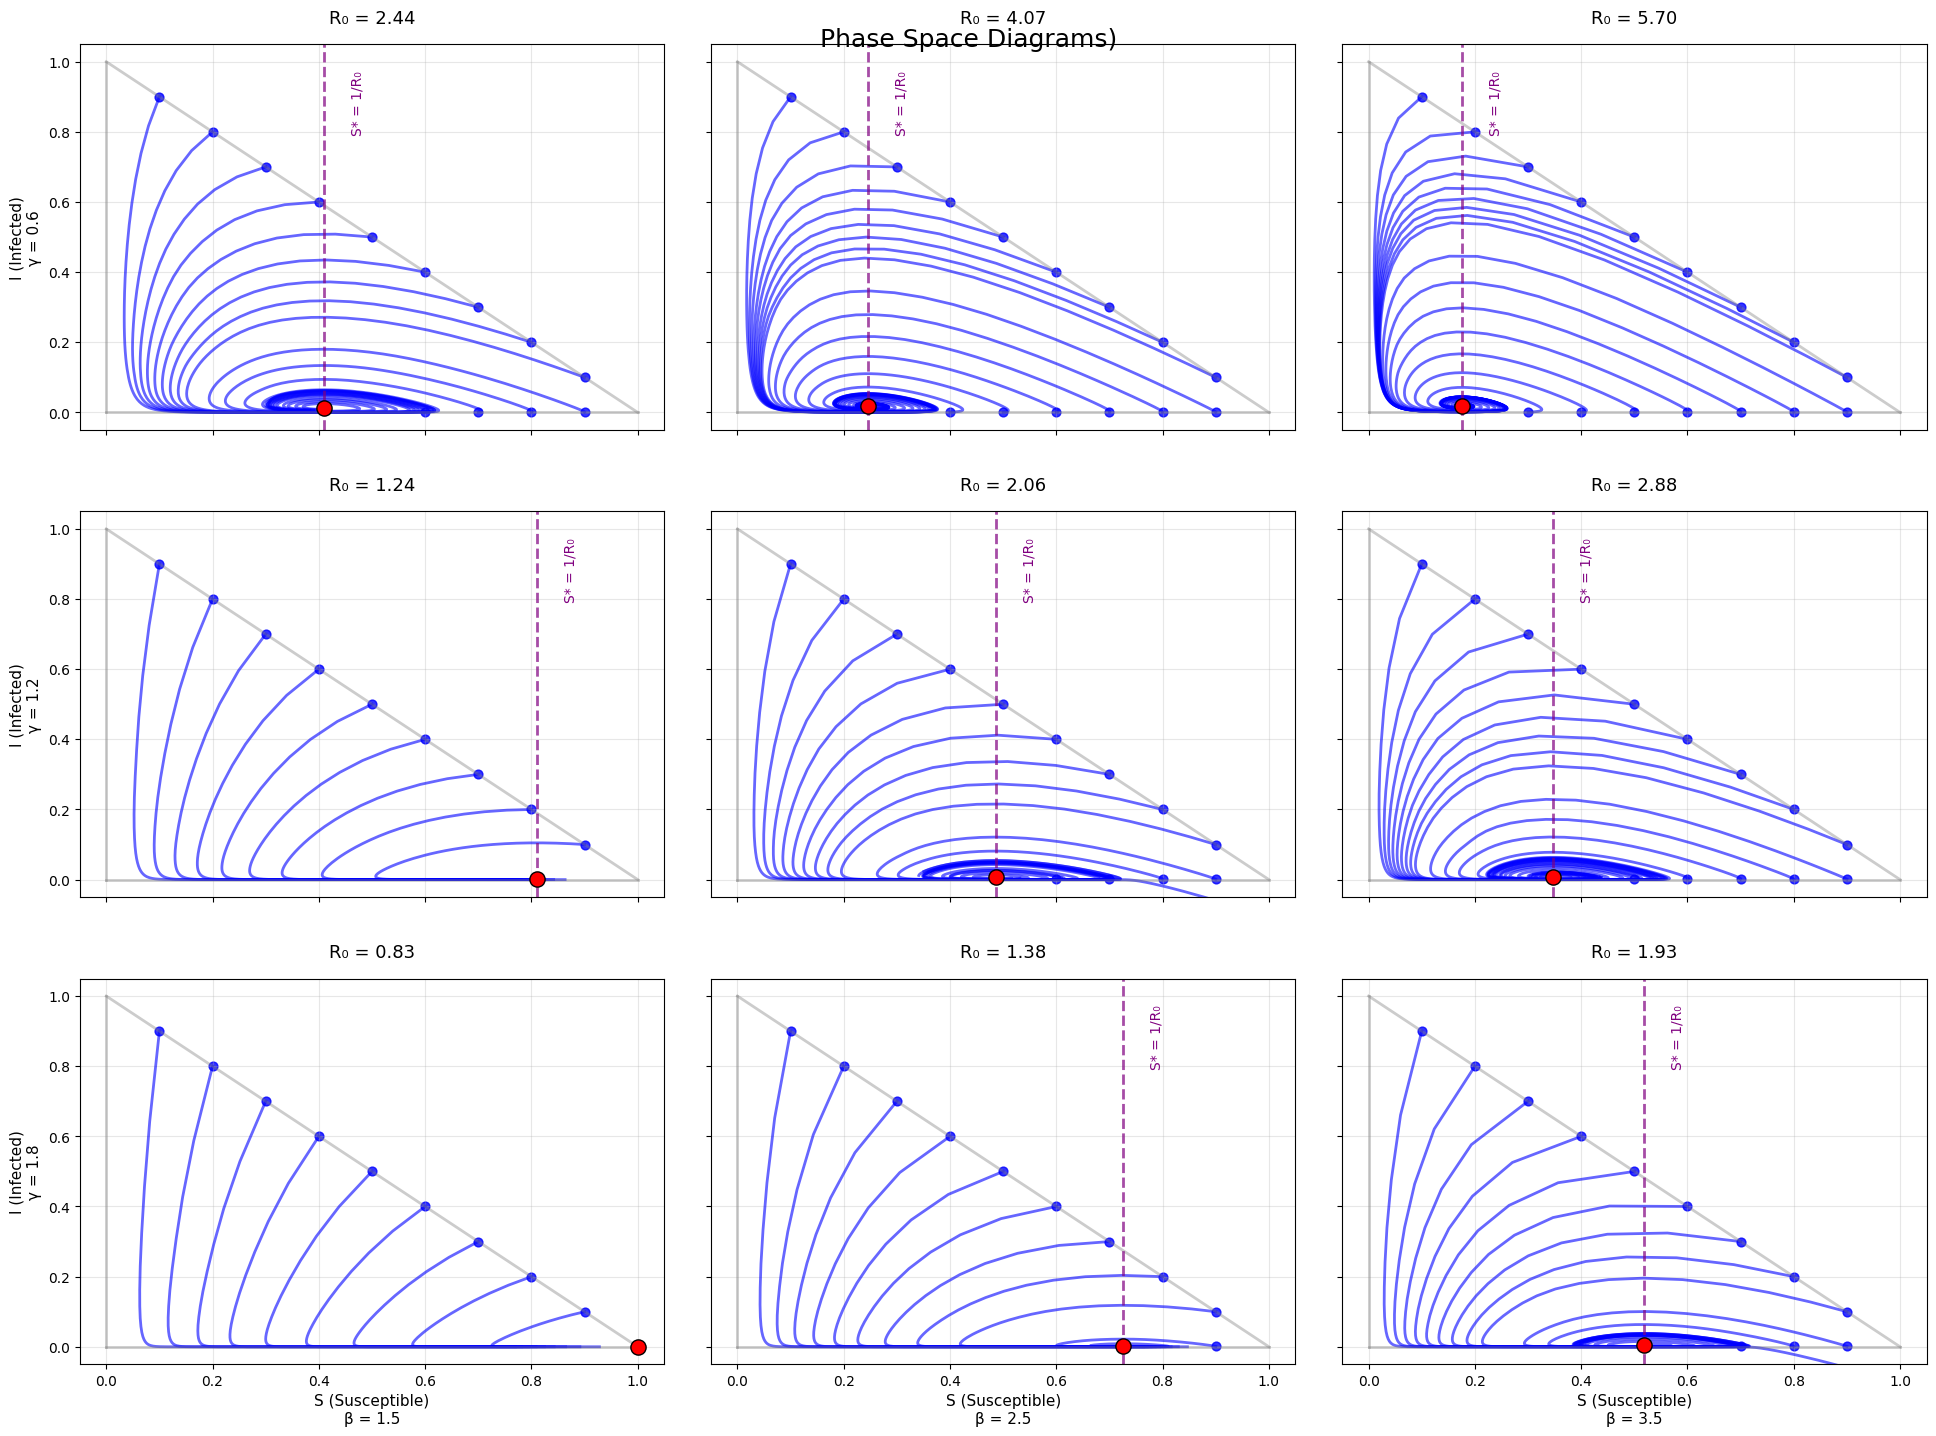

In [267]:
fig2, axes2 = plt.subplots(nrows=len(gamma_values), ncols=len(beta_values), 
                          figsize=(20, 15), sharex=True, sharey=True)

# Range of initial S values
S0_list = np.linspace(0.1, 1.0, 10)

for i, gamma in enumerate(gamma_values):
    for j, beta in enumerate(beta_values):
        
        R0 = beta / (gamma + mu)
        
        # Calculate equilibrium points
        if R0 > 1:
            S_eq = 1/R0                              # S* = 1/R0
            I_eq = mu * (R0 - 1) / beta             # I* = μ(R0-1)/β
            R_eq = 1 - S_eq - I_eq                  # R* = 1 - S* - I*
        else:
            S_eq = 1.0
            I_eq = 0.0
            R_eq = 0.0
            
        # Plot trajectories from different initial conditions
        for S0_val in S0_list:
            
            # Type 1: High infection start
            I0_high = 1 - S0_val
            R0_high = 0.0
            
            if I0_high > 0:
                solution = solve_ivp(lambda t, y: SIR_demography(t, y, beta, gamma, mu),
                                   (0, 100), [S0_val, I0_high, R0_high], 
                                   t_eval=np.linspace(0, 100, 500), method='RK45')
                
                S_traj, I_traj, R_traj = solution.y
                
                # Plot trajectory
                axes2[i,j].plot(S_traj, I_traj, 'blue', alpha=0.6, linewidth=2)
                axes2[i,j].scatter(S0_val, I0_high, c='blue', s=40, alpha=0.8)
            
            # Type 2: Low infection start
            if (S0_val > (1/R0 + 0.1)) and (R0 > 1):
                I0_low = 0.001
                R0_low = 1 - S0_val - I0_low
                
                if R0_low >= 0:  # Ensure valid initial condition
                    solution = solve_ivp(lambda t, y: SIR_demography(t, y, beta, gamma, mu),
                                       (0, 100), [S0_val, I0_low, R0_low], 
                                       t_eval=np.linspace(0, 100, 500), method='RK45')
                    
                    S_traj, I_traj, R_traj = solution.y
                    
                    # Plot trajectory
                    axes2[i,j].plot(S_traj, I_traj, 'blue', alpha=0.6, linewidth=2)
                    axes2[i,j].scatter(S0_val, I0_low, c='blue', s=40, alpha=0.8)
        
        # Draw triangle boundary
        axes2[i,j].plot([0, 1], [1, 0], 'gray', alpha=0.4, linewidth=2, label='S + I = 1')
        axes2[i,j].plot([0, 1], [0, 0], 'gray', alpha=0.4, linewidth=2, label='I = 0')
        axes2[i,j].plot([0, 0], [0, 1], 'gray', alpha=0.4, linewidth=2, label='S = 0')
        
        # Plot equilibrium point
        axes2[i,j].scatter(S_eq, I_eq, c='red', s=120, marker='o', 
                          label='Equilibrium', zorder=5, edgecolors='black')
        
        # Add nullclines
        if R0 > 1:
            axes2[i,j].axvline(x=S_eq, color='purple', linestyle='--', alpha=0.7, 
                              linewidth=2, label='dI/dt = 0')
            axes2[i,j].text(S_eq + 0.05, 0.8, f'S* = 1/R₀', 
                           color='purple', fontsize=10, rotation=90)
        
        # Formatting
        axes2[i,j].set_xlim(-0.05, 1.05)
        axes2[i,j].set_ylim(-0.05, 1.05)
        axes2[i,j].set_title(f'R₀ = {R0:.2f}', fontsize=13, pad=15)
        axes2[i,j].tick_params(labelsize=10)
        axes2[i,j].grid(True, alpha=0.3)
        
        # Add parameter info
        if i == len(gamma_values)-1:  # bottom row
            axes2[i,j].set_xlabel(f'S (Susceptible)\nβ = {beta}', fontsize=11)
        if j == 0:  # left column  
            axes2[i,j].set_ylabel(f'I (Infected)\nγ = {gamma}', fontsize=11)

plt.tight_layout(pad=3.0)
plt.suptitle('Phase Space Diagrams)', 
             fontsize=18, y=0.96)
plt.show()

Parameters: β=3.5, γ=0.5, μ=0.0143
R₀ = 6.81


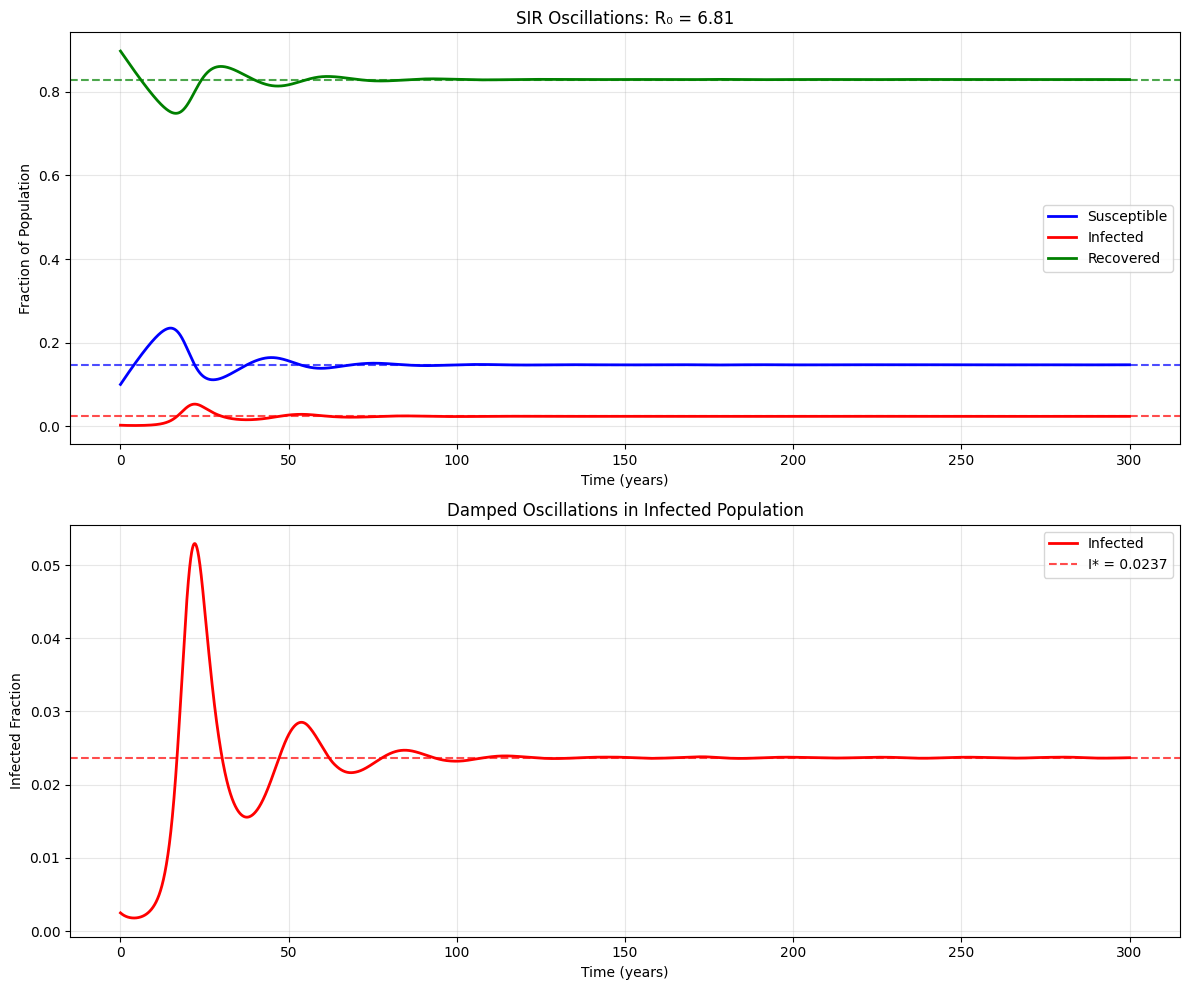

In [268]:
# Use parameters that show clear oscillations

#FIXME: Adjust time period to see oscillations clearly
beta_osc = 3.5
gamma_osc = 0.5  
mu_osc = 1.0/70.0
R0_osc = beta_osc / (gamma_osc + mu_osc)


print(f"Parameters: β={beta_osc}, γ={gamma_osc}, μ={mu_osc:.4f}")
print(f"R₀ = {R0_osc:.2f}")

# Long-term simulation to see oscillations
t_long = np.linspace(0, 300, 20000)
solution_osc = solve_ivp(lambda t, y: SIR_demography(t, y, beta_osc, gamma_osc, mu_osc),
                        (0, 300), [0.1, 2.5*10e-4, 1 - 0.1 - 2.5*10e-4], t_eval=t_long, method='RK45')

t_osc = solution_osc.t
S_osc, I_osc, R_osc = solution_osc.y

# Plot oscillatory behavior
fig3, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Time series
ax1.plot(t_osc, S_osc, 'b-', label='Susceptible', linewidth=2)
ax1.plot(t_osc, I_osc, 'r-', label='Infected', linewidth=2)
ax1.plot(t_osc, R_osc, 'g-', label='Recovered', linewidth=2)

# Add equilibrium lines
S_eq_osc = 1/R0_osc
I_eq_osc = mu_osc * (R0_osc - 1) / beta_osc
R_eq_osc = 1 - S_eq_osc - I_eq_osc

ax1.axhline(y=S_eq_osc, color='b', linestyle='--', alpha=0.7)
ax1.axhline(y=I_eq_osc, color='r', linestyle='--', alpha=0.7)
ax1.axhline(y=R_eq_osc, color='g', linestyle='--', alpha=0.7)

ax1.set_xlabel('Time (years)')
ax1.set_ylabel('Fraction of Population') 
ax1.set_title(f'SIR Oscillations: R₀ = {R0_osc:.2f}')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Focus on infected population to see oscillations clearly
ax2.plot(t_osc, I_osc, 'r-', linewidth=2, label='Infected')
ax2.axhline(y=I_eq_osc, color='r', linestyle='--', alpha=0.7, 
           label=f'I* = {I_eq_osc:.4f}')
ax2.set_xlabel('Time (years)')
ax2.set_ylabel('Infected Fraction')
ax2.set_title('Damped Oscillations in Infected Population')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [269]:
burn_in = 50.0
m = t >= burn_in
Ifft = I[m] - I[m].mean()
dt = t[1] - t[0]
freqs = np.fft.rfftfreq(Ifft.size, d=dt)
F = np.fft.rfft(Ifft)

pos = freqs > 0
peak = np.argmax(np.abs(F[pos]))
f_dom = freqs[pos][peak]            # cycles/year
T_dom = 1.0 / f_dom                 # years
amp_pp = I[m].max() - I[m].min()    # peak-to-peak (post-transient)

print(f"Dominant frequency: {f_dom:.4f} cycles/year")
print(f"Corresponding period: {T_dom:.2f} years")
print(f"Peak-to-peak amplitude of I(t): {amp_pp:.4f}")

Dominant frequency: 0.0200 cycles/year
Corresponding period: 50.06 years
Peak-to-peak amplitude of I(t): 0.0368


### Part 2.2

In [270]:
def SIR_mortality(t, y, beta, gamma, mu, rho):
    """
    SIR model with mortality induced infection
    """
    
    S, I, R = y
    
    # SIR equations with mortality induced infection
    dSdt = mu - beta*S*I - mu*S   # births - infection - natural death
    dIdt=beta*S* I - (mu + gamma)*I / (1 - rho)
    dRdt = gamma*I - mu*R
    
    return [dSdt, dIdt, dRdt]   

In [271]:
S0, I0 = 0.99, 0.01
R0_init = 1 - S0 - I0

mu = 1/70

gamma = 0.25            
beta_values  = [1.5, 2.5, 3.5]  # SWEEP β (per year)
rho_values   = [0.3, 0.6, 0.9]       # Few ρ to see effect

t_span = (0, 100)
t_eval = np.linspace(0, 100, 1000)   # slight bump in resolution


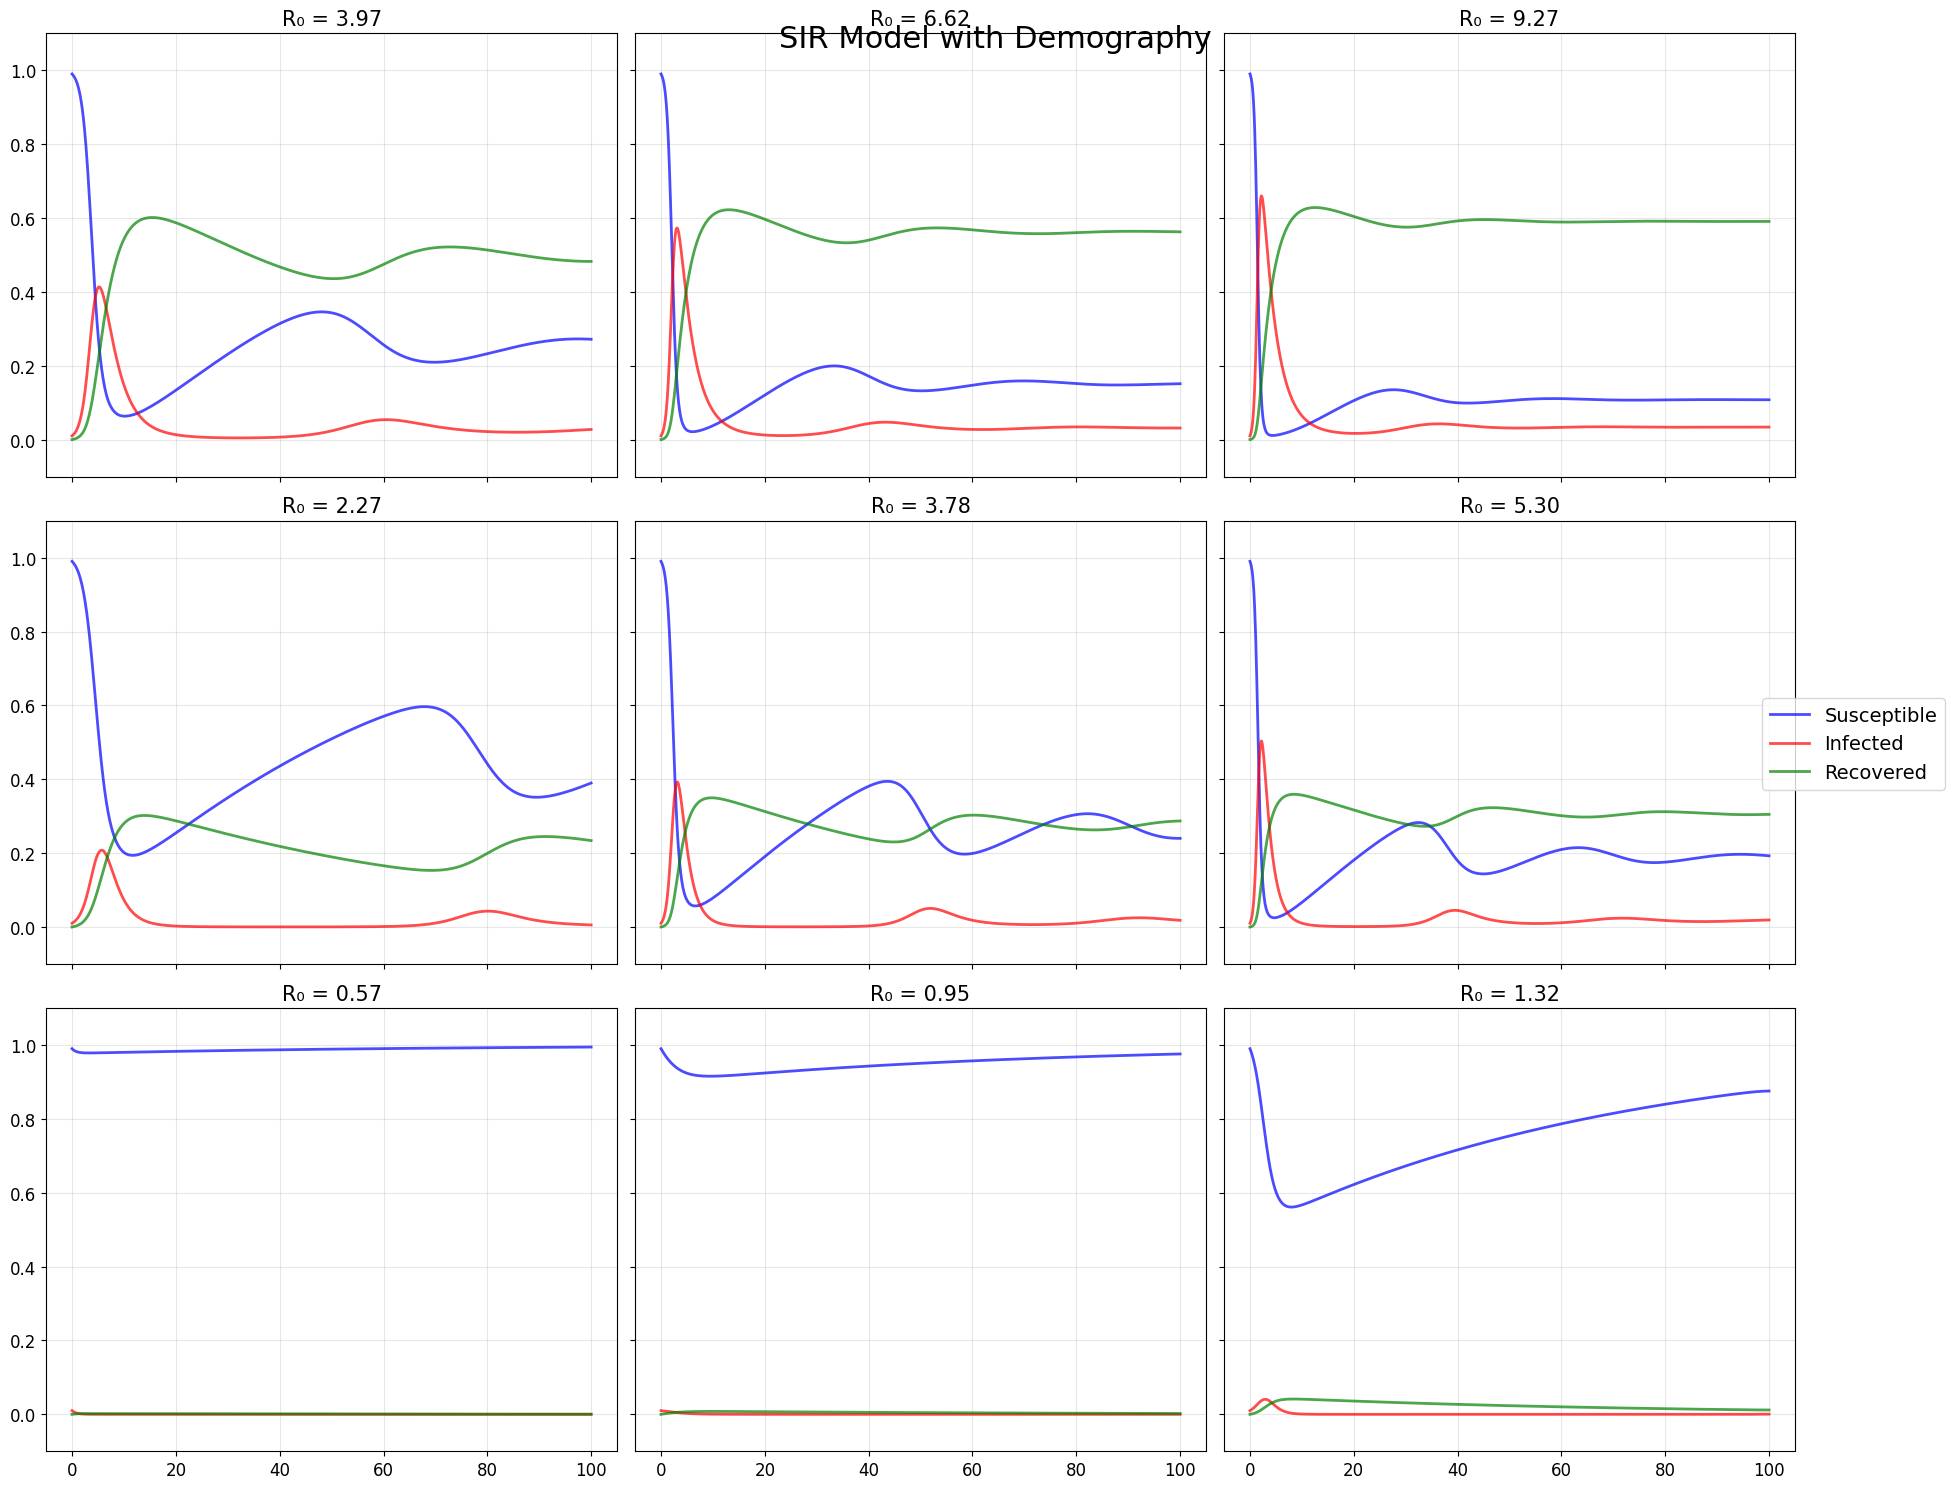

In [272]:
fig, axes = plt.subplots(nrows=len(rho_values), ncols=len(beta_values), 
                        figsize=(20, 15), sharex=True, sharey=True)

for i, rho in enumerate(rho_values):
    for j, beta in enumerate(beta_values):
        
        # Calculate R0 
        R0 = beta * (1-rho) / (gamma + mu)
        
        # Solve the system
        solution = solve_ivp(lambda t, y: SIR_mortality(t, y, beta, gamma, mu, rho),
                           t_span, [S0, I0, R0_init], t_eval=t_eval, 
                           method='RK45')
        
        t = solution.t
        S, I, R = solution.y
        
        # Plot time series
        axes[i,j].plot(t, S, 'b-', alpha=0.7, linewidth=2, label='Susceptible')
        axes[i,j].plot(t, I, 'r-', alpha=0.7, linewidth=2, label='Infected') 
        axes[i,j].plot(t, R, 'g-', alpha=0.7, linewidth=2, label='Recovered')
        
        axes[i,j].set_ylim(-0.1, 1.1)
        axes[i,j].set_title(f'R₀ = {R0:.2f}', fontsize=15)
        axes[i,j].tick_params(labelsize=12)
        axes[i,j].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('SIR Model with Demography', fontsize=22, y=0.98)
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(0.98, 0.5), fontsize=14)

plt.subplots_adjust(right=0.90)
plt.show()

Critical rho_c ≈ 0.794 (R0(rho_c)=1)


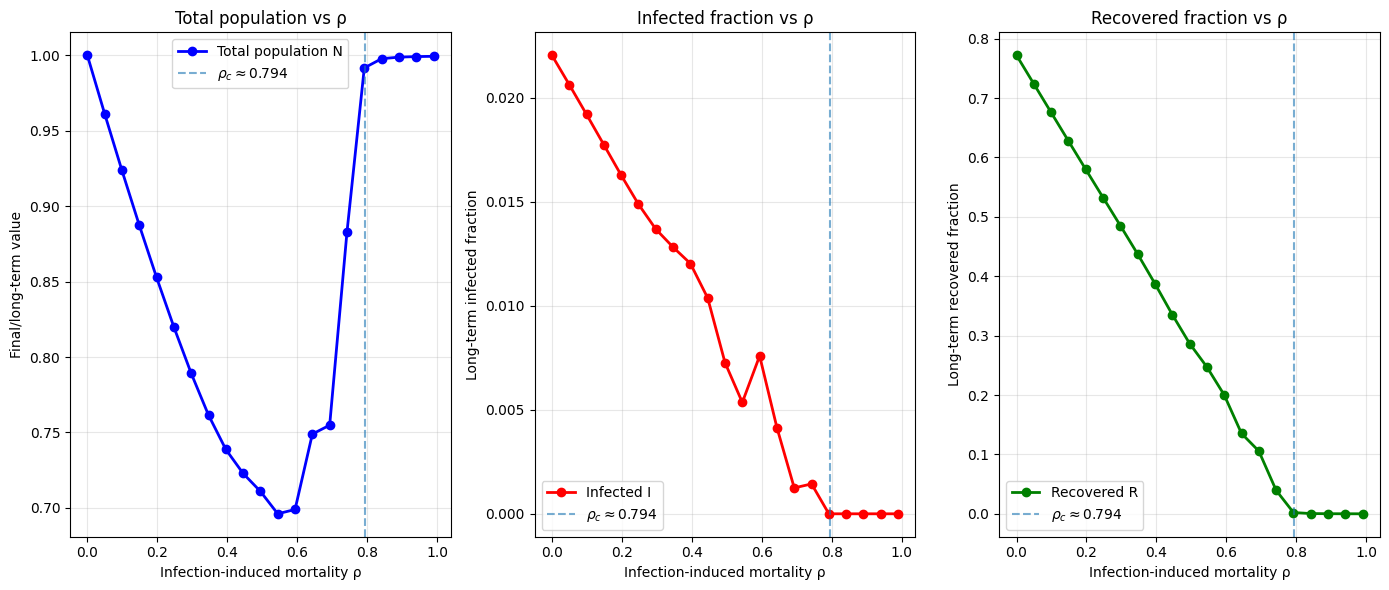

In [273]:
# Parameters (per year)
beta, gamma, mu = 2.5, 0.5, 1/70

# Initial conditions
S0, I0, R0 = 0.99, 0.01, 0.0
y0 = [S0, I0, R0]

# Time horizon and sampling
t_end = 200
t_eval = np.linspace(0, t_end, 2000)

# Sweep rho all the way to 1.0 (inclusive)
rho_values = np.linspace(0.0, 0.99, 21)

final_pop, final_inf, final_rec = [], [], []

for rho in rho_values:
    sol = solve_ivp(lambda t, y: SIR_mortality(t, y, beta, gamma, mu, rho),
                    (0, t_end), y0, t_eval=t_eval, rtol=1e-8, atol=1e-10)
    if not sol.success:
        raise RuntimeError(f"Solver failed for rho={rho}: {sol.message}")

    S, I, R = sol.y
    # Clamp tiny negatives from numerics
    S = np.clip(S, 0, None); I = np.clip(I, 0, None); R = np.clip(R, 0, None)
    N = S + I + R

    # Average over last 10% of the trajectory
    k = max(1, int(0.10 * len(t_eval)))
    final_pop.append(np.mean(N[-k:]))
    final_inf.append(np.mean(I[-k:]))
    final_rec.append(np.mean(R[-k:]))

# --- Plots ---
plt.figure(figsize=(14,6))

plt.subplot(1,3,1)
plt.plot(rho_values, final_pop, 'o-b', lw=2, label='Total population N')
plt.xlabel("Infection-induced mortality ρ")
plt.ylabel("Final/long-term value")
plt.title("Total population vs ρ")
plt.grid(alpha=0.3)
plt.legend()

plt.subplot(1,3,2)
plt.plot(rho_values, final_inf, 'o-r', lw=2, label='Infected I')
plt.xlabel("Infection-induced mortality ρ")
plt.ylabel("Long-term infected fraction")
plt.title("Infected fraction vs ρ")
plt.grid(alpha=0.3)
plt.legend()

plt.subplot(1,3,3)
plt.plot(rho_values, final_rec, 'o-g', lw=2, label='Recovered R')
plt.xlabel("Infection-induced mortality ρ")
plt.ylabel("Long-term recovered fraction")
plt.title("Recovered fraction vs ρ")
plt.grid(alpha=0.3)
plt.legend()

rho_c = max(0.0, min(1.0, 1.0 - (gamma + mu)/beta))
print(f"Critical rho_c ≈ {rho_c:.3f} (R0(rho_c)=1)")

for ax in plt.gcf().axes:  # after your three subplots are created
    ax.axvline(rho_c, linestyle='--', alpha=0.6, label=fr'$\rho_c \approx {rho_c:.3f}$')
    ax.legend()

plt.tight_layout()
plt.show()

### Part 3.1: The SEIR Model

Numerically solve the SEIR model and analyse the behavior of the model under different parameter conditions. We can do this using phase space, plots and other plots.

In [274]:
# SEIR model differential equations with demographics
def SEIR(y, t, beta, gamma, mu, sigma):
    S, I, R, E = y
    dSdt = mu - beta * S * I - mu * S
    dIdt = sigma * E - (mu + gamma) * I
    dRdt = gamma * I - mu * R
    dEdt = beta * S * I - (mu + sigma) * E
    return [dSdt, dIdt, dRdt, dEdt]